# EEG Random Forest Workflow (v1)

This notebook demonstrates the complete pipeline for sleep stage classification from mouse EEG/EMG data.

## Table of Contents

1. [Setup and Configuration](#1-setup-and-configurationsetup)
2. [Data Exploration](#2-data-exploration)
3. [Feature Extraction](#3-feature-extraction)
4. [Data Merging and Cleaning](#4-data-merging-and-cleaning)
5. [Model Training]()
6. [Model Evaluation]()
7. [Results Analysis]()

## 1. Setup and Configuration

In [1]:
# Import required libraries
import os
import sys
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Add src to path for imports
sys.path.append(str(Path.cwd().parent / "src"))

# Import our custom modules
from src.config import (
    PROJECT_ROOT, DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR,
    FREQUENCY_BANDS, SAMPLING_RATE, EPOCH_DURATION, FEATURE_GROUPS, EEG_FILTER_RANGE, EMG_FILTER_RANGE, SLEEP_STAGE_MAPPING,
    MODEL_PARAMS, CLASS_WEIGHTS
)
from src.data.extract_features import EEGFeatureExtractor, extract_features_from_directory
from src.data.merge_data import DataMerger, merge_data_directory
from src.models.train_model import SleepStageClassifier
from src.models.evaluate_model import ModelEvaluator
from src.visualization.visualize import plot_feature_distributions, plot_sleep_stage_distribution

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("Setup complete!")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")

Setup complete!
Project root: /Users/davidrivas/Developer/repos/eeg_random_forest
Data directory: /Users/davidrivas/Developer/repos/eeg_random_forest/data


In [2]:
# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display configuration settings
print("Configuration Summary:")
print("-" * 40)
print(f"Sampling Rate: {SAMPLING_RATE} Hz")
print(f"Epoch Duration: {EPOCH_DURATION} seconds")
print(f"Frequency Bands: {list(FREQUENCY_BANDS.keys())}")
print(f"Feature Groups: {list(FEATURE_GROUPS.keys())}")
print(f"Sleep Stage Mapping: {SLEEP_STAGE_MAPPING}")

Configuration Summary:
----------------------------------------
Sampling Rate: 400 Hz
Epoch Duration: 4 seconds
Frequency Bands: ['delta', 'theta', 'alpha', 'beta', 'sigma', 'gamma']
Feature Groups: ['absolute', 'relative', 'ratios', 'spectral', 'emg']
Sleep Stage Mapping: {'Wake': 'Wake', 'Wake ': 'Wake', 'REM': 'REM', 'REM ': 'REM', 'Non REM': 'Non REM', 'Non REM ': 'Non REM'}


## 2. Data Exploration

In [3]:
# Set up data directories (adjust paths as needed)
raw_data_path = Path("../data/raw/Raw_Data_Sleep")  # Go up one level to access data
labels_path = Path("../data/raw/Raw_Data_Sleep")    # Same location for labels

# Create output directories if they don't exist
for path in [INTERIM_DATA_DIR, PROCESSED_DATA_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Looking for data in:")
print(f"  Raw EDF files: {raw_data_path}")
print(f"  Sleep stage labels: {labels_path}")

Looking for data in:
  Raw EDF files: ../data/raw/Raw_Data_Sleep
  Sleep stage labels: ../data/raw/Raw_Data_Sleep


In [5]:
# Discover available data files
def discover_data_files(data_path):
    """Discover and summarize available data files."""
    edf_files = list(data_path.rglob("*.edf"))
    
    if not edf_files:
        print(f"No EDF files found in {data_path}")
        print("Please ensure your data is in the correct location.")
        return []
    
    print(f"Found {len(edf_files)} EDF files:")
    
    # Group by animal/subject
    animals = {}
    for file in edf_files:
        # Extract animal ID from path or filename
        animal_id = file.parent.name if file.parent.name != data_path.name else file.stem.split('_')[0]
        if animal_id not in animals:
            animals[animal_id] = []
        animals[animal_id].append(file.name)
    
    for animal, files in animals.items():
        print(f"  {animal}: {len(files)} files")
        for file in files[:3]:  # Show first 3 files
            print(f"    - {file}")
        if len(files) > 3:
            print(f"    ... and {len(files)-3} more")
    
    return edf_files

# Discover label files
def discover_label_files(labels_path):
    """Discover and summarize available label files."""
    txt_files = list(labels_path.rglob("*.txt"))
    
    if not txt_files:
        print(f"No label files found in {labels_path}")
        return []
    
    print(f"Found {len(txt_files)} label files:")
    
    # Sample a few files to understand format
    for file in txt_files[:3]:
        print(f"  - {file.name}")
    
    return txt_files

# Discover data
edf_files = discover_data_files(raw_data_path)
label_files = discover_label_files(labels_path)

Found 80 EDF files:
  gk-3055: 4 files
    - gk-3055_wm-day1.edf
    - gk-3055_wm-day3.edf
    - gk-3055_wm-day2.edf
    ... and 1 more
  gk-3544: 4 files
    - gk-3544_baseline.edf
    - gk-3544_wm-day3.edf
    - gk-3544_wm-day2.edf
    ... and 1 more
  gk-1677: 4 files
    - gk-1677_wm-day1.edf
    - gk-1677_wm-day3.edf
    - gk-1677_wm-day2.edf
    ... and 1 more
  gk-3534: 4 files
    - gk-3534_baseline.edf
    - gk-3534_wm-day3.edf
    - gk-3534_wm-day2.edf
    ... and 1 more
  gk-3040: 4 files
    - gk-3040_wm-day2.edf
    - gk-3040_wm-day3.edf
    - gk-3040_wm-day1.edf
    ... and 1 more
  gk-1729: 4 files
    - gk-1729_baseline.edf
    - gk-1729_wm-day1.edf
    - gk-1729_wm-day2.edf
    ... and 1 more
  gk-1811: 4 files
    - gk-1811_wm-day3.edf
    - gk-1811_wm-day2.edf
    - gk-1811_wm-day1.edf
    ... and 1 more
  gk-2011: 4 files
    - gk-2011_baseline.edf
    - gk-2011_wm-day2.edf
    - gk-2011_wm-day3.edf
    ... and 1 more
  gk-0985: 4 files
    - gk-0985_baseline.edf
  

Examining sample file: gk-3055_wm-day1.edf
  Channels: ['EEG1.2', 'EEG2.2', 'EMG.2']
  Sampling rate: 400.0 Hz
  Duration: 86400.0 seconds
  Data shape: (3, 34560000)
Reading 0 ... 12000  =      0.000 ...    30.000 secs...


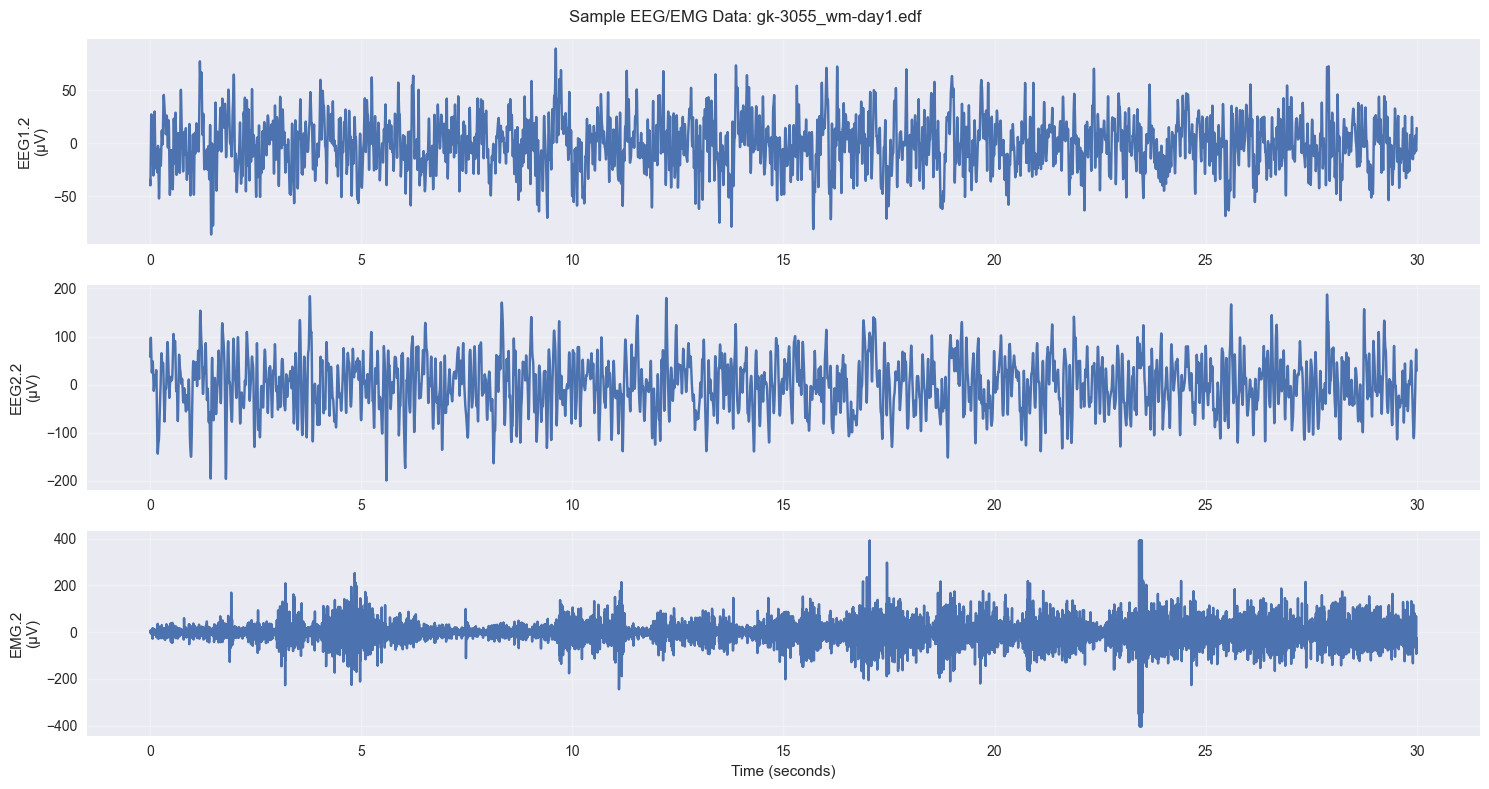

In [6]:
# Examine a sample EDF file (if available)
if edf_files:
    import mne
    
    sample_file = edf_files[0]
    print(f"Examining sample file: {sample_file.name}")
    
    try:
        # Load the file
        raw = mne.io.read_raw_edf(str(sample_file), preload=False, verbose=False)
        
        print(f"  Channels: {raw.ch_names}")
        print(f"  Sampling rate: {raw.info['sfreq']} Hz")
        print(f"  Duration: {raw.times[-1]:.1f} seconds")
        print(f"  Data shape: {raw.get_data().shape}")
        
        # Plot a short segment
        if len(raw.ch_names) >= 3:
            fig, axes = plt.subplots(3, 1, figsize=(15, 8))
            
            # Load first 30 seconds of data
            raw_segment = raw.copy().crop(tmax=30).load_data()
            data = raw_segment.get_data()
            times = raw_segment.times
            
            # Plot first 3 channels
            for i in range(min(3, len(raw.ch_names))):
                axes[i].plot(times, data[i] * 1e6)  # Convert to microvolts
                axes[i].set_ylabel(f'{raw.ch_names[i]}\n(μV)')
                axes[i].grid(True, alpha=0.3)
            
            axes[-1].set_xlabel('Time (seconds)')
            plt.suptitle(f'Sample EEG/EMG Data: {sample_file.name}')
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error reading file: {e}")
else:
    print("No EDF files found. Please add your data files to continue.")

## 3. Feature Extraction

In [7]:
# Initialize feature extractor
feature_extractor = EEGFeatureExtractor()
features_output_dir = INTERIM_DATA_DIR / "features"
features_output_dir.mkdir(parents=True, exist_ok=True)

print("Feature Extraction Configuration:")
print(f"  Frequency bands: {FREQUENCY_BANDS}")
print(f"  EEG filter range: {EEG_FILTER_RANGE} Hz")
print(f"  EMG filter range: {EMG_FILTER_RANGE} Hz")
print(f"  Output directory: {features_output_dir}")

Feature Extraction Configuration:
  Frequency bands: {'delta': [0.5, 4], 'theta': [4, 8], 'alpha': [8, 13], 'beta': [13, 30], 'sigma': [12, 16], 'gamma': [30, 45]}
  EEG filter range: [0.5, 45] Hz
  EMG filter range: [10, None] Hz
  Output directory: /Users/davidrivas/Developer/repos/eeg_random_forest/data/interim/features


In [8]:
# Extract features from all EDF files
if edf_files:
    print(f"Extracting features from {len(edf_files)} files...")
    
    # Extract features (this may take some time for large datasets)
    feature_files = extract_features_from_directory(raw_data_path, features_output_dir)
    
    print(f"Feature extraction complete!")
    print(f"  Processed: {len(feature_files)} files")
    print(f"  Saved to: {features_output_dir}")
    
    # Show sample feature file
    if feature_files:
        sample_features = pd.read_csv(feature_files[0])
        print(f"\nSample features from {feature_files[0].name}:")
        print(f"  Shape: {sample_features.shape}")
        print(f"  Columns: {list(sample_features.columns)}")
        print(f"  Sample data:")
        print(sample_features.head(3))
        
else:
    print("No EDF files available for feature extraction.")

2025-07-15 13:18:12,109 - INFO - Found 80 EDF files
2025-07-15 13:18:12,110 - INFO - Processing ../data/raw/Raw_Data_Sleep/WT/gk-3055/gk-3055_wm-day1.edf


Extracting features from 80 files...


2025-07-15 13:18:17,109 - INFO - Saved features to /Users/davidrivas/Developer/repos/eeg_random_forest/data/interim/features/gk-3055/gk-3055_wm-day1.csv
2025-07-15 13:18:17,137 - INFO - Processing ../data/raw/Raw_Data_Sleep/WT/gk-3055/gk-3055_wm-day3.edf
2025-07-15 13:18:22,417 - INFO - Saved features to /Users/davidrivas/Developer/repos/eeg_random_forest/data/interim/features/gk-3055/gk-3055_wm-day3.csv
2025-07-15 13:18:22,453 - INFO - Processing ../data/raw/Raw_Data_Sleep/WT/gk-3055/gk-3055_wm-day2.edf
2025-07-15 13:18:27,746 - INFO - Saved features to /Users/davidrivas/Developer/repos/eeg_random_forest/data/interim/features/gk-3055/gk-3055_wm-day2.csv
2025-07-15 13:18:27,776 - INFO - Processing ../data/raw/Raw_Data_Sleep/WT/gk-3055/gk-3055_baseline.edf
2025-07-15 13:18:32,760 - INFO - Saved features to /Users/davidrivas/Developer/repos/eeg_random_forest/data/interim/features/gk-3055/gk-3055_baseline.csv
2025-07-15 13:18:32,792 - INFO - Processing ../data/raw/Raw_Data_Sleep/WT/gk-354

Feature extraction complete!
  Processed: 80 files
  Saved to: /Users/davidrivas/Developer/repos/eeg_random_forest/data/interim/features

Sample features from gk-3055_wm-day1.csv:
  Shape: (21600, 24)
  Columns: ['Delta_Power', 'Theta_Power', 'Alpha_Power', 'Beta_Power', 'Sigma_Power', 'Gamma_Power', 'Rel_Delta', 'Rel_Theta', 'Rel_Alpha', 'Rel_Beta', 'Rel_Sigma', 'Rel_Gamma', 'Theta_Delta_Ratio', 'Alpha_Delta_Ratio', 'Beta_Theta_Ratio', 'Beta_Delta_Ratio', 'Spectral_Edge_95', 'Spectral_Edge_50', 'Spectral_Entropy', 'EMG_RMS', 'EMG_MAV', 'EMG_Variance', 'EMG_ZCR', 'Artifact']
  Sample data:
    Delta_Power   Theta_Power   Alpha_Power    Beta_Power   Sigma_Power  \
0  6.413294e-10  5.346730e-10  6.878888e-10  3.642896e-10  1.594202e-10   
1  3.857923e-10  6.458149e-10  7.409335e-10  2.396936e-10  1.285595e-10   
2  3.947029e-10  3.609185e-10  7.784434e-10  2.292458e-10  1.038222e-10   

    Gamma_Power  Rel_Delta  Rel_Theta  Rel_Alpha  Rel_Beta  ...  \
0  9.465185e-14   0.314185   0.2030

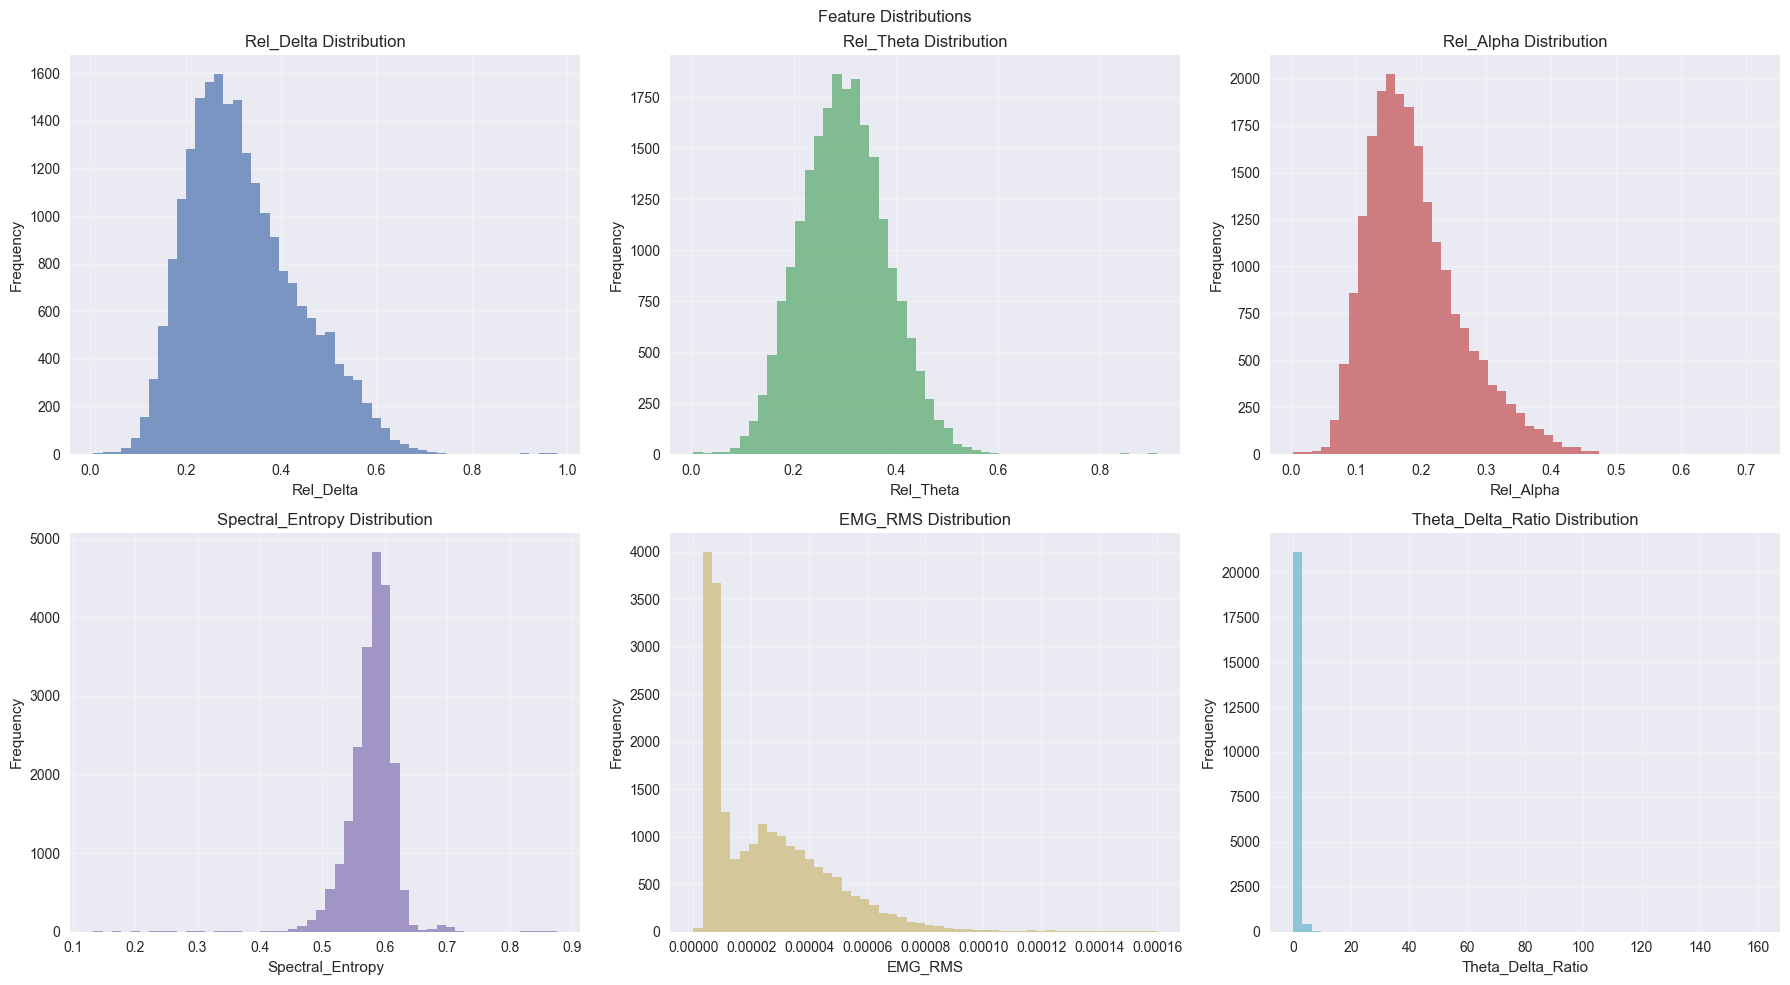

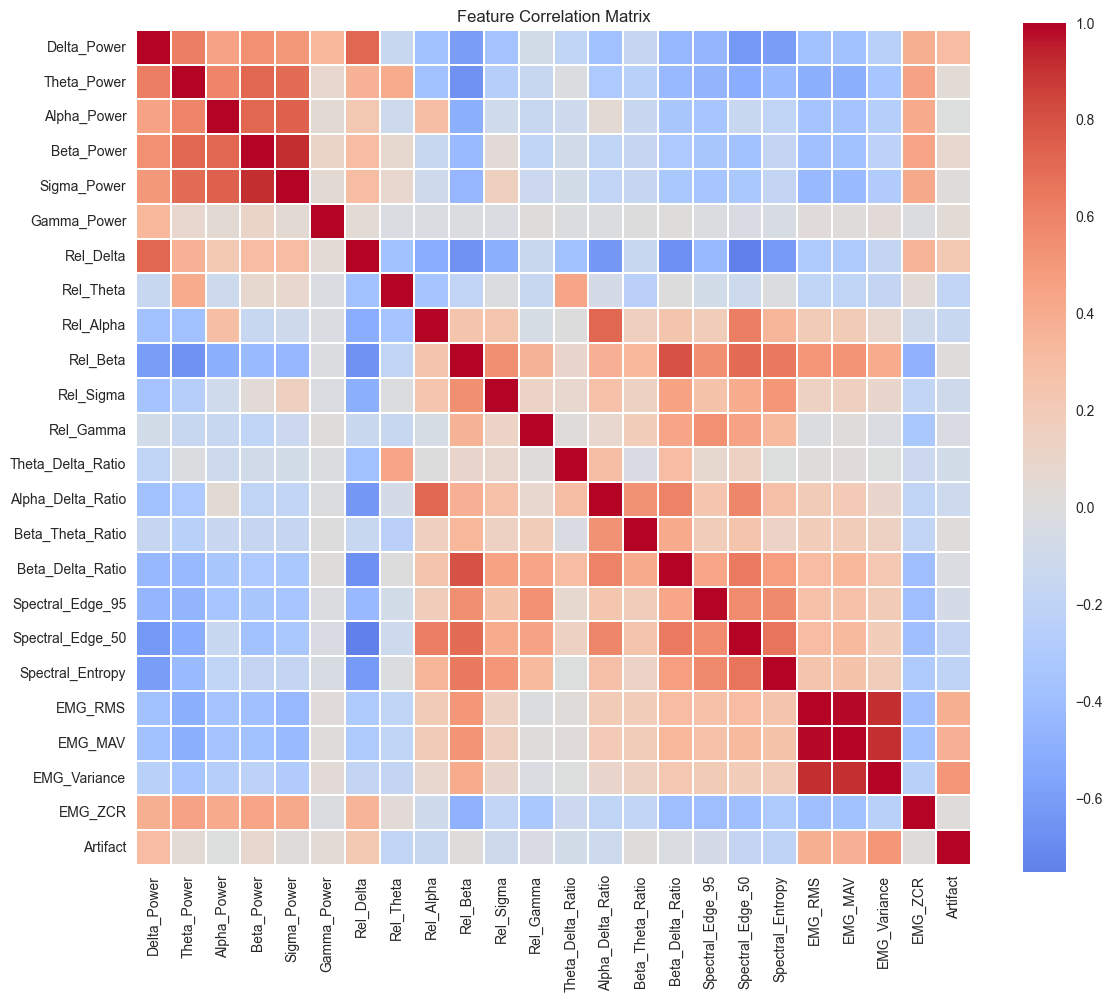

In [9]:
# Visualize extracted features
if feature_files:
    # Load feature data for visualization
    sample_features = pd.read_csv(feature_files[0])
    
    # Plot feature distributions
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    # Select key features to visualize
    key_features = ['Rel_Delta', 'Rel_Theta', 'Rel_Alpha', 'Spectral_Entropy', 'EMG_RMS', 'Theta_Delta_Ratio']
    
    for i, feature in enumerate(key_features):
        if feature in sample_features.columns:
            axes[i].hist(sample_features[feature], bins=50, alpha=0.7, color=f'C{i}')
            axes[i].set_title(f'{feature} Distribution')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Feature Distributions')
    plt.tight_layout()
    plt.show()
    
    # Feature correlation heatmap
    numeric_features = sample_features.select_dtypes(include=[np.number])
    correlation_matrix = numeric_features.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
                square=True, linewidths=0.1)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

## 4. Data Merging and Cleaning

In [10]:
# Initialize data merger
data_merger = DataMerger(log_mismatches=True)
merged_output_dir = PROCESSED_DATA_DIR
merged_output_dir.mkdir(parents=True, exist_ok=True)

print("Data Merging Configuration:")
print(f"  Features directory: {features_output_dir}")
print(f"  Labels directory: {labels_path}")
print(f"  Output directory: {merged_output_dir}")

Data Merging Configuration:
  Features directory: /Users/davidrivas/Developer/repos/eeg_random_forest/data/interim/features
  Labels directory: ../data/raw/Raw_Data_Sleep
  Output directory: /Users/davidrivas/Developer/repos/eeg_random_forest/data/processed


In [11]:
# Merge features with labels
if label_files and feature_files:
    print(f"Merging {len(feature_files)} feature files with {len(label_files)} label files...")
    
    merged_files = merge_data_directory(features_output_dir, labels_path, merged_output_dir)
    
    print(f"Data merging complete!")
    print(f"  Successfully merged: {len(merged_files)} files")
    
    # Check for mismatch log
    mismatch_log_file = merged_output_dir / "mismatch_log.csv"
    if mismatch_log_file.exists():
        mismatch_log = pd.read_csv(mismatch_log_file)
        print(f"Mismatches logged: {len(mismatch_log)} entries")
        print(f"  Check {mismatch_log_file} for details")
        
        # Show summary of mismatches
        if len(mismatch_log) > 0:
            print("\nMismatch Summary:")
            print(mismatch_log.groupby('successfully_merged').size())

Merging 80 feature files with 80 label files...
Found 80 feature files
Found 80 label files
Found 80 matching pairs
Processing gk-3976_wm-day3.csv...
  Features: 21600 rows
  Labels: 21600 rows
Merged: 21600 rows saved
Processing gk-1730_wm-day3.csv...
  Features: 21600 rows
  Labels: 21600 rows
Merged: 21600 rows saved
Processing gk-0985_wm-day1.csv...
  Features: 21600 rows
  Labels: 21600 rows
Merged: 21600 rows saved
Processing gk-2011_wm-day3.csv...
  Features: 21600 rows
  Labels: 21600 rows
Merged: 21600 rows saved
Processing gk-1729_wm-day3.csv...
  Features: 21600 rows
  Labels: 21600 rows
Merged: 21600 rows saved
Processing gk-2016_wm-day1.csv...
  Features: 21600 rows
  Labels: 21600 rows
Merged: 21600 rows saved
Processing gk-1573_wm-day3.csv...
  Features: 21600 rows
  Labels: 21600 rows
Merged: 21600 rows saved
Processing gk-3977_wm-day1.csv...
  Features: 21600 rows
  Labels: 21600 rows
Merged: 21600 rows saved
Processing gk-2016_baseline.csv...
  Features: 21600 rows
  

2025-07-15 13:26:17,424 - INFO - Successfully merged 61 files


Merged: 21600 rows saved
Processing gk-3051_baseline.csv...
  Features: 21600 rows
  Labels: 21599 rows
Mismatch: 1 row difference - logged

=== MERGE RESULTS ===
Perfect matches: 61
Mismatches: 19
Saved mismatch log: /Users/davidrivas/Developer/repos/eeg_random_forest/data/processed/mismatch_log.csv
Mismatch log saved with 19 failures
Data merging complete!
  Successfully merged: 61 files
Mismatches logged: 19 entries
  Check /Users/davidrivas/Developer/repos/eeg_random_forest/data/processed/mismatch_log.csv for details

Mismatch Summary:
successfully_merged
False    19
dtype: int64


### Resolve mismatches

In [12]:
# Resolve mismatches from the mismatch log
if mismatch_log_file.exists() and len(mismatch_log) > 0:
    print(f"\n{'='*60}")
    print(f"RESOLVING MISMATCHES")
    print(f"{'='*60}")
    
    # Import the resolver
    from src.data.resolve_mismatch import resolve_all_mismatches, diagnose_file
    
    # Show detailed mismatch analysis
    print(f"\nMismatch Analysis:")
    single_row_mismatches = mismatch_log[mismatch_log['difference'].abs() == 1]
    large_mismatches = mismatch_log[mismatch_log['difference'].abs() > 1]
    
    print(f"  Single-row differences (±1): {len(single_row_mismatches)} files")
    print(f"  Large differences (>1): {len(large_mismatches)} files")
    
    # Show details of large mismatches
    if len(large_mismatches) > 0:
        print(f"\nLarge differences:")
        for _, row in large_mismatches.iterrows():
            filename = Path(row['feature_file']).name
            print(f"  {filename}: {row['features_count']} vs {row['labels_count']} (diff: {row['difference']})")
    
    # Resolve all mismatches
    print(f"\nResolving mismatches...")
    resolved_results = resolve_all_mismatches(mismatch_log_file, merged_output_dir)
    
    # Show results
    print(f"\n{'='*60}")
    print(f"RESOLUTION RESULTS")
    print(f"{'='*60}")
    
    total_attempted = len(resolved_results['fixed']) + len(resolved_results['failed'])
    print(f"Total files attempted: {total_attempted}")
    print(f"Successfully resolved: {len(resolved_results['fixed'])} files")
    print(f"Failed to resolve: {len(resolved_results['failed'])} files")
    
    if len(resolved_results['fixed']) > 0:
        print(f"\nSuccessfully resolved files:")
        for file_path in resolved_results['fixed']:
            print(f"  {file_path.name}")
    
    if len(resolved_results['failed']) > 0:
        print(f"\nFailed to resolve files:")
        for file_path in resolved_results['failed']:
            print(f"  {file_path.name}")
    
    # Update total merged files count
    total_merged = len(merged_files) + len(resolved_results['fixed'])
    print(f"\nFINAL MERGE SUMMARY:")
    print(f"  Perfect matches merged: {len(merged_files)} files")
    print(f"  Mismatches resolved: {len(resolved_results['fixed'])} files")
    print(f"  Total successfully merged: {total_merged} files")
    print(f"  Unresolved issues: {len(resolved_results['failed'])} files")
    
    # Check for remaining issues
    if len(resolved_results['failed']) > 0:
        print(f"\nSome files could not be resolved automatically.")
        print(f"   These may require manual investigation.")
    else:
        print(f"\nAll mismatches successfully resolved!")
        
else:
    print(f"\nNo mismatches found - all files merged successfully!")


RESOLVING MISMATCHES

Mismatch Analysis:
  Single-row differences (±1): 18 files
  Large differences (>1): 1 files

Large differences:
  gk-3977_baseline.csv: 21600 vs 20699 (diff: 901)

Resolving mismatches...
Loaded mismatch log with 19 entries

Processing: gk-2016_baseline.csv
Difference: 1
  Original counts: 21600 features, 21599 labels
  Difference: 1

  STEP 1: No large gaps detected (difference = 1)

  STEP 2: Fixing single-row difference...
    Features has 1 extra row - removing last row
  After single-row fix: 21599 features, 21599 labels (diff: 0)

  STEP 3: Merging data...
  Final result: 21599 rows merged (1 rows removed)
  Saved to: gk-2016_baseline_resolved.csv
Successfully resolved

Processing: gk-1811_baseline.csv
Difference: 1
  Original counts: 21600 features, 21599 labels
  Difference: 1

  STEP 1: No large gaps detected (difference = 1)

  STEP 2: Fixing single-row difference...
    Features has 1 extra row - removing last row
  After single-row fix: 21599 feature

### Clean merged data

In [13]:
# Import the cleaner
from src.data.clean_data import clean_all_merged_files

# Clean all merged files
print(f"\nCleaning all merged files...")
cleaning_results = clean_all_merged_files(merged_output_dir, merged_output_dir)

# Show detailed results
print(f"\n{'='*60}")
print(f"CLEANING RESULTS")
print(f"{'='*60}")

total_attempted = len(cleaning_results['cleaned']) + len(cleaning_results['failed'])
print(f"Total files attempted: {total_attempted}")
print(f"Successfully cleaned: {len(cleaning_results['cleaned'])} files")
print(f"Failed to clean: {len(cleaning_results['failed'])} files")

if len(cleaning_results['cleaned']) > 0:
    print(f"\nSuccessfully cleaned files:")
    for file_path in cleaning_results['cleaned']:
        print(f"  {file_path.name}")

if len(cleaning_results['failed']) > 0:
    print(f"\nFailed to clean files:")
    for file_path in cleaning_results['failed']:
        print(f"  {file_path.name}")

# Check cleaning log
cleaning_log_file = merged_output_dir / "cleaning_log.csv"
if cleaning_log_file.exists():
    cleaning_log = pd.read_csv(cleaning_log_file)
    print(f"\nCLEANING STATISTICS:")
    
    total_original = cleaning_log['original_rows'].sum()
    total_cleaned = cleaning_log['cleaned_rows'].sum()
    total_removed = cleaning_log['rows_removed'].sum()
    removal_pct = (total_removed / total_original) * 100
    
    print(f"  Total original rows: {total_original:,}")
    print(f"  Total cleaned rows: {total_cleaned:,}")
    print(f"  Total rows removed: {total_removed:,} ({removal_pct:.1f}%)")
    print(f"  Cleaning log saved to: {cleaning_log_file}")
    
    # Show removal distribution
    if total_removed > 0:
        print(f"\n  Files with most removals:")
        top_removals = cleaning_log.nlargest(3, 'rows_removed')[['file', 'rows_removed', 'original_rows']]
        for _, row in top_removals.iterrows():
            filename = Path(row['file']).name
            pct = (row['rows_removed'] / row['original_rows']) * 100
            print(f"    {filename}: {row['rows_removed']:,} removed ({pct:.1f}%)")

# Final summary
print(f"\nFINAL PIPELINE SUMMARY:")
print(f"  Original feature files: {len(feature_files)}")
print(f"  Perfect matches merged: {len(merged_files)}")
print(f"  Mismatches resolved: {len(resolved_results['fixed'])}")
print(f"  Files cleaned: {len(cleaning_results['cleaned'])}")
print(f"  Ready for analysis: {len(cleaning_results['cleaned'])} files")

if len(resolved_results['failed']) > 0 or len(cleaning_results['failed']) > 0:
    total_failed = len(resolved_results['failed']) + len(cleaning_results['failed'])
    print(f"Files requiring attention: {total_failed}")
else:
    print(f"All files processed successfully!")


Cleaning all merged files...
Found 80 merged files to clean
Processing: gk-3055_wm-day1_merged.csv
  Original: 21600 rows
  Original sleep stages: {'IS N-R': 281, 'IS R-N': 20, 'Non REM': 7320, 'Non REM X': 4, 'REM': 995, 'REM X': 2, 'Wake': 12622, 'Wake X': 356}
  Cleaned: 20937 rows (663 rows removed)
  Cleaned sleep stages: {'Non REM': 7320, 'REM': 995, 'Wake': 12622}
Cleaned: gk-3055_wm-day1_merged.csv
Processing: gk-3055_wm-day3_merged.csv
  Original: 21600 rows
  Original sleep stages: {'IS N-R': 250, 'IS R-N': 115, 'Non REM': 7923, 'Non REM X': 1, 'REM': 1103, 'REM X': 11, 'Wake': 11892, 'Wake X': 305}
  Cleaned: 20918 rows (682 rows removed)
  Cleaned sleep stages: {'Non REM': 7923, 'REM': 1103, 'Wake': 11892}
Cleaned: gk-3055_wm-day3_merged.csv
Processing: gk-3055_wm-day2_merged.csv
  Original: 21600 rows
  Original sleep stages: {'IS N-R': 283, 'IS R-N': 86, 'Non REM': 7657, 'REM': 1105, 'REM X': 9, 'Wake': 12177, 'Wake X': 283}
  Cleaned: 20939 rows (661 rows removed)
  Cle